In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl import heterograph
import dgl.function as fn
import dgl.utils as dgl_utils
from functools import partial
from dgl.nn.pytorch import RelGraphConv


import numpy as np
import pygraphviz as pgv

from sklearn.model_selection import train_test_split
import networkx as nx

from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import time
import utils
from base import BaseRGCN

Load graph as a dictionary

In [127]:
# graph_dict = utils.read_dict_file('../data/clean/graph_dict.txt')
# g = heterograph(graph_dict)

In [6]:
def plot_graph(nxg):
    ag = pgv.AGraph(strict=False, directed=True)
    for u, v, k in nxg.edges(keys=True):
        ag.add_edge(u, v, label=k)
    ag.layout('dot')
    ag.draw('graph.png')
    ag.edge_attr['front_size']=0.1

# plot_graph(g.metagraph)

### Build Model

In [128]:
class EmbeddingLayer(nn.Module):
    def __init__(self, num_nodes, h_dim):
        super(EmbeddingLayer, self).__init__()
        # create an embedding value [0,1] for each node of the graph
        self.embedding = torch.nn.Embedding(num_nodes, h_dim)

    def forward(self, g, h, r, norm):
        return self.embedding(h.squeeze())

class RGCN(BaseRGCN):
    def build_input_layer(self):
        return EmbeddingLayer(self.num_nodes, self.h_dim)

    def build_hidden_layer(self, idx):
        # build a number of hidden layer according to the parameter
        # add a relu activation function except for the last layer
        act = F.relu if idx < self.num_hidden_layers - 1 else None
        return RelGraphConv(self.h_dim, self.h_dim, self.num_rels, 'basis',
                self.num_bases, activation=act, self_loop=True,
                dropout=self.dropout)

class LinkPredict(nn.Module):
    def __init__(self, in_dim, h_dim, num_rels, num_bases=-1,
                 num_hidden_layers=1, dropout=0, use_cuda=False, reg_param=0):
        """
        Arguments:
        - in_dim (int) -- input feature size
        - h_dim  (int) -- output feature size
        - num_rels (int) -- # relations
        - num_bases (int) -- # bases
        - num_hidden_layers (int) -- # hidden layers
        - dropout (float) -- [0,1] dropout rate
        - use_cuda (bool)
        - reg_param (float) -- regularization parameter
        """
        super(LinkPredict, self).__init__()
        # build RGCN layer
        # 2 x num_rels as both directions are considered
        self.rgcn = RGCN(in_dim, h_dim, h_dim, num_rels * 2, num_bases,
                         num_hidden_layers, dropout, use_cuda)
        # define regularization
        self.reg_param = reg_param
        # define relations and normalize them
        self.w_relation = nn.Parameter(torch.Tensor(num_rels, h_dim))
        nn.init.xavier_uniform_(self.w_relation,
                                gain=nn.init.calculate_gain('relu'))

    def calc_score(self, embedding, triplets):
        # apply DistMult for scoring
        # embedding contains the embedding values of the node after the 
        #   propagation within the RGCN Block layer
        # triplets contains all triples resulting from the negative sampling process
        s = embedding[triplets[:,0]]
        r = self.w_relation[triplets[:,1]]
        o = embedding[triplets[:,2]]
        score = torch.sum(s * r * o, dim=1)
        return score

    def forward(self, g, h, r, norm):
        return self.rgcn.forward(g, h, r, norm)

    def regularization_loss(self, embedding):
        return torch.mean(embedding.pow(2)) + torch.mean(self.w_relation.pow(2))

    def get_loss(self, g, embed, triplets, labels):
        # triplets is a list of data samples (positive and negative)
        # each row in the triplets is a 3-tuple of (source, relation, destination)
        
        # The score is computed with the value-by-value multiplication of
        #   the embedding values of data produced by the negative sampling process
        #   and sum them using the vertical dimension
        
        score = self.calc_score(embed, triplets)
        predict_loss = F.binary_cross_entropy_with_logits(score, labels)
        reg_loss = self.regularization_loss(embed)
        return predict_loss + self.reg_param * reg_loss

def node_norm_to_edge_norm(g, node_norm):
    g = g.local_var()
    # convert to edge norm
    g.ndata['norm'] = node_norm
    g.apply_edges(lambda edges : {'norm' : edges.dst['norm']})
    return g.edata['norm']

### Load the graph

In [129]:
graph = np.load('../data/clean/graph.npy')

In [130]:
num_drugs = 8094
num_diseases = 11171
num_genes = 18643

### Node degree distribution

In [131]:
def generate_deg_dist(graph, data_type='whole',title='for the whole graph'):
    if data_type == "whole":
        edges1 = Counter(list(Counter(graph[:,0]).values()))
        edges2 = Counter(list(Counter(graph[:,2]).values()))
    
    elif data_type == "gene":
        graph1 = graph[graph[:,0]>=11171+8079]
        graph2 = graph[graph[:,2]>=11171+8079+18643]
        edges1 = Counter(list(Counter(graph1[:,0]).values()))
        edges2 = Counter(list(Counter(graph2[:,2]).values()))
        
    elif data_type == "disease":
        graph1 = graph[(graph[:,0]>=8079) & (graph[:,0]<11171+8079)]
        graph2 = graph[(graph[:,2]>=8079) & (graph[:,2]<11171+8079)]
        edges1 = Counter(list(Counter(graph1[:,0]).values()))
        edges2 = Counter(list(Counter(graph2[:,2]).values()))
    elif data_type == "drug":
        graph1 = graph[graph[:,0]<8079]
        graph2 = graph[graph[:,2]<8079]
        edges1 = Counter(list(Counter(graph1[:,0]).values()))
        edges2 = Counter(list(Counter(graph2[:,2]).values()))
    edges = edges1+edges2
    plt.scatter(list(edges.keys()),list(edges.values()))
    plt.title('Degree Distribution '+title)
    plt.xlabel('Node Degree')
    plt.ylabel('Number of Nodes')
    plt.yscale('log')
    

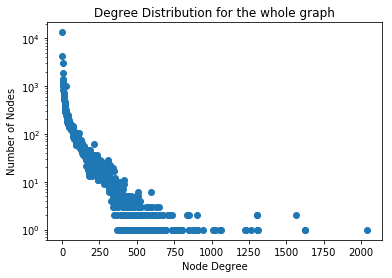

In [132]:
generate_deg_dist(graph, title='for the whole graph')

In [60]:
graph_gene = graph[((graph[:,0]>=num_diseases+num_drugs) | (graph[:,2]>=num_diseases+num_drugs)),:]
graph_disease = graph[(((graph[:,0]>=num_drugs) & (graph[:,0]<num_diseases+num_drugs)) 
                       | (graph[:,2]>=8079) & (graph[:,2]<num_diseases+num_drugs)),:]
graph_drug = graph[((graph[:,0]<num_drugs) | (graph[:,2]<num_drugs)),:]

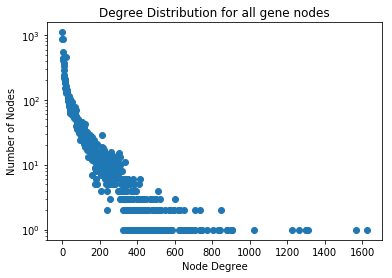

In [61]:
generate_deg_dist(graph_gene, 'gene', title='for all gene nodes')

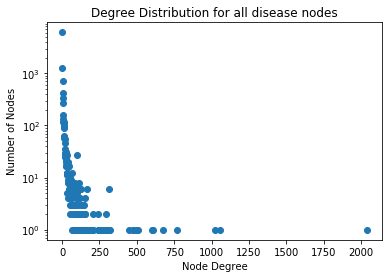

In [62]:
generate_deg_dist(graph_disease, 'disease',title='for all disease nodes')

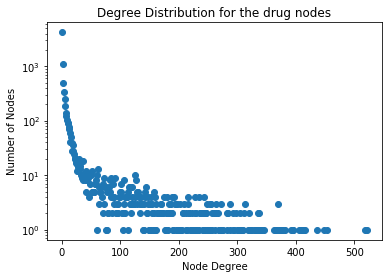

In [63]:
generate_deg_dist(graph,'drug', title='for the drug nodes')

### Pruning nodes with small degree

In [10]:
G = nx.Graph()

In [11]:
nx_edges = [(node1, node2) for (node1, node2) in zip(graph[:,0],graph[:,2])]

In [12]:
G.add_edges_from(nx_edges)

In [13]:
remove = [node for node,degree in dict(G.degree()).items() if degree < 200]

In [14]:
small_graph = graph[~((np.isin(graph[:,0], remove)) | (np.isin(graph[:,2], remove))),:]

In [15]:
small_graph.shape

(297109, 3)

---------------

In [133]:
num_nodes = len(list(set(np.unique(graph[:,0])).union(set(np.unique(graph[:,2])))))
num_rels = np.unique(graph[:,1]).shape[0]
num_edges = graph.shape[0]

In [134]:
train_val, test_data = train_test_split(graph, test_size=0.1, random_state=0)
train_data, val_data = train_test_split(train_val, test_size=0.2, random_state=0)

train_val_data = train_val[train_val[:,1] == 0]
val_data = torch.LongTensor(val_data[val_data[:,1] == 0])
test_data = torch.LongTensor(test_data[test_data[:,1] == 0])

### Only focus on drug-disease edge for validation

In [135]:
test_graph, test_rel, test_norm = utils.build_test_graph(
        num_nodes, num_rels, train_val_data)

Test graph:
# nodes: 37908, # edges: 14244


In [136]:
test_deg = test_graph.in_degrees(
                range(test_graph.number_of_nodes())).float().view(-1, 1)
test_node_id = torch.arange(0, num_nodes, dtype=torch.long).view(-1, 1)
test_rel = torch.from_numpy(test_rel)
test_norm = node_norm_to_edge_norm(test_graph, torch.from_numpy(test_norm).view(-1, 1))

Example parameters:
```
args = {'dropout': 0.2,
        'n_hidden': 5,
        'gpu': 1,
        'lr': 1e-2,
        'n_bases': 100,
        'n_layers': 2,
        'n_epochs': 10,
        'dataset': 'FB15k-237',
        'eval_batch_size': 500,
        'regularization': 0.01,
        'grad_norm': 1.0,
        'graph_batch_size': 3000,
        'graph_split_size': 0.5,
        'negative_sample': 10,
        'evaluate_every': 10}
```

In [147]:
# model params
model_param = {
    'in_dim'   : num_nodes,
    'h_dim'    : 200, # output feature size
    'num_rels' : num_rels,
    'dropout'  : 0.2,
    'use_cuda' : True,
    'reg_param': 0.01
}
use_cuda = model_param['use_cuda']
torch.cuda.set_device(0)

In [148]:
# create the model
model = LinkPredict(in_dim   = model_param['in_dim'],
                    h_dim    = model_param['h_dim'],
                    num_rels = model_param['num_rels'],
                    dropout  = model_param['dropout'],
                    use_cuda = model_param['use_cuda'],
                    reg_param= model_param['reg_param'])
if use_cuda:
    model.cuda()

In [149]:
# build adj list and calculate degrees for sampling
adj_list, degrees = utils.get_adj_and_degrees(num_nodes, train_data)

In [150]:
# optimizer
optimizer = torch.optim.Adam(model.parameters())

In [151]:
epoch = 0
epoch_mult_eval = 1000 # multiplication of n epochs to indicate when to evaluate
best_mrr = 0
forward_time = []
backward_time = []
eval_batch = 1000
model_state_file = 'model_state.pth'

In [152]:
sample_graph_param = {
    'sample_size'  : 5000, # edges to sample
    'split_size'   : 0.5,
    'negative_rate': 10,
}

In [153]:
print("start training...")
while epoch < 10001:
    model.train()
    epoch += 1

    # Perform edge neighborhood sampling to generate training graph and data
    # The training stage is performed on a sample graph (not the entire graph)
    g, node_id, edge_type, node_norm, data, labels = \
        utils.generate_sampled_graph_and_labels(
            train_data, 
            sample_graph_param['sample_size'],
            sample_graph_param['split_size'],
            num_rels, 
            adj_list,
            degrees,
            sample_graph_param['negative_rate'])
    
    print("Finished edge sampling")
    
    # set node/edge feature
    node_id = torch.from_numpy(node_id).view(-1, 1).long()
    edge_type = torch.from_numpy(edge_type)
    edge_norm = node_norm_to_edge_norm(g, torch.from_numpy(node_norm).view(-1, 1))
    data, labels = torch.from_numpy(data), torch.from_numpy(labels)
    deg = g.in_degrees(range(g.number_of_nodes())).float().view(-1, 1)
    if use_cuda:
        node_id, deg = node_id.cuda(), deg.cuda()
        edge_type, edge_norm = edge_type.cuda(), edge_norm.cuda()
        data, labels = data.cuda(), labels.cuda()

    t0 = time.time()
    embed = model(g, node_id, edge_type, edge_norm)
    loss = model.get_loss(g, embed, data, labels)
    t1 = time.time()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip gradients
    optimizer.step()
    t2 = time.time()

    forward_time.append(t1 - t0)
    backward_time.append(t2 - t1)
    print("Epoch {:04d} | Loss {:.4f} | Best MRR {:.4f} | Forward {:.4f}s | Backward {:.4f}s".
              format(epoch, loss.item(), best_mrr, forward_time[-1], backward_time[-1]))

    optimizer.zero_grad()

    # validation
    if epoch % epoch_mult_eval == 0:
        print('Run evaluation...')
        # perform validation on CPU because full graph is too large
        if use_cuda: 
            model.cpu()
            model.eval()
            embed = model(test_graph, test_node_id, test_rel, test_norm)
            mrr = utils.calc_mrr(embed, model.w_relation, torch.LongTensor(train_val_data),
                                 val_data, test_data, hits=[1, 3, 10], eval_bz=eval_batch,
                                 eval_p='filtered')
        # save best model
        if mrr > best_mrr:
            best_mrr = mrr
            best_mrr = mrr
            torch.save({'state_dict': model.state_dict(), 'epoch': epoch},
                       model_state_file)
        if use_cuda:
            model.cuda()


start training...
# sampled nodes: 5727
# sampled edges: 5000
# nodes: 5727, # edges: 5000
Finished edge sampling
Epoch 0001 | Loss 2.0609 | Best MRR 0.0000 | Forward 0.0065s | Backward 0.0246s
# sampled nodes: 5754
# sampled edges: 5000
# nodes: 5754, # edges: 5000
Finished edge sampling
Epoch 0002 | Loss 2.0348 | Best MRR 0.0000 | Forward 0.0065s | Backward 0.0243s
# sampled nodes: 5745
# sampled edges: 5000
# nodes: 5745, # edges: 5000
Finished edge sampling
Epoch 0003 | Loss 1.9944 | Best MRR 0.0000 | Forward 0.0065s | Backward 0.0247s
# sampled nodes: 5701
# sampled edges: 5000
# nodes: 5701, # edges: 5000
Finished edge sampling
Epoch 0004 | Loss 1.9737 | Best MRR 0.0000 | Forward 0.0066s | Backward 0.0252s
# sampled nodes: 5741
# sampled edges: 5000
# nodes: 5741, # edges: 5000
Finished edge sampling
Epoch 0005 | Loss 1.9324 | Best MRR 0.0000 | Forward 0.0065s | Backward 0.0245s
# sampled nodes: 5763
# sampled edges: 5000
# nodes: 5763, # edges: 5000
Finished edge sampling
Epoch 

In [144]:
ep

LinkPredict(
  (rgcn): RGCN(
    (layers): ModuleList(
      (0): EmbeddingLayer(
        (embedding): Embedding(37908, 150)
      )
      (1): RelGraphConv(
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )
)